In [23]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda, serializers
import chainer.functions as F
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import time
import datetime
from net import Net, MLP

In [24]:
n_epoch = 3000000 #エポック
batchsize = 5000 #バッチサイズ
printout_interval = 50000 #何エポック毎に誤差をプリントアウトするか

bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 20 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [25]:
xp = cuda.cupy if use_gpu is True else np

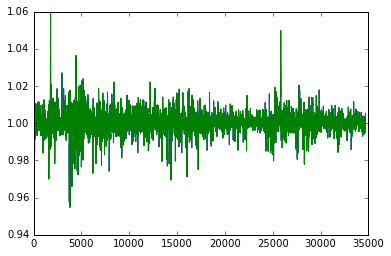

In [26]:
raw_data = []
f = open('nikkei5min.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    if row[7] == "":
        continue
    raw_data.append(row[7])
raw_data = np.asarray(raw_data, dtype=np.float32)
data_x = raw_data[:-1]
data_y = raw_data[1:]
train_data_x, test_data_x = data_x[:int(len(data_x) * 0.8)], data_x[:int(len(data_x) * 0.2)]
train_data_y, test_data_y = data_y[:int(len(data_y) * 0.8)], data_y[:int(len(data_y) * 0.2)]

plt.plot(train_data_x)
plt.plot(train_data_y)

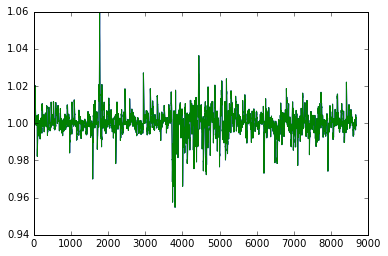

In [27]:
plt.plot(test_data_x)
plt.plot(test_data_y)

In [28]:
#ネットワークを試す関数
def evaluate(model, x, y):
    evaluator = model.copy()
    evaluator.reset_state()
    out = evaluator.predict(x)
    error = F.mean_squared_error(out, y)
    return chainer.cuda.to_cpu(out.data), error.data

In [29]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
test_loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
x_cache = []
y_cache = []
x_chainer_variable = chainer.Variable(xp.asarray([[x] for x in train_data_x], dtype=np.float32))
y_chainer_variable = chainer.Variable(xp.asarray([[y] for y in train_data_y], dtype=np.float32))
test_data_x_chainer_variable = chainer.Variable(xp.asarray([[x] for x in test_data_x], dtype=np.float32))
test_data_y_chainer_variable = chainer.Variable(xp.asarray([[y] for y in test_data_y], dtype=np.float32))
prev_time = time.time()
for i in range(jump * n_epoch):
    if len(x_cache) <= i % jump:
        x_cache.append( chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs])))
        y_cache.append( chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs])))
    x = x_cache[i % jump]
    y = y_cache[i % jump]
    #x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    #y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % printout_interval == 0:
            now = time.time()
            elapsed_time = now - prev_time
            prev_time = now
            speed = printout_interval / elapsed_time
            eta = datetime.timedelta(seconds = (n_epoch - epoch) / speed)
            eta = datetime.timedelta(seconds = eta.seconds)
            print('epoch {0}, error {1}, {2:.2f} epoch/s, eta {3}'.format(epoch, loss_data * len(x) / length, speed, eta))
        loss.append(evaluate(model, x_chainer_variable, y_chainer_variable)[1])
        test_loss.append(evaluate(model, test_data_x_chainer_variable, test_data_y_chainer_variable)[1])
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 50000, error 0.0014798053307458758, 60.61 epoch/s, eta 13:31:15
epoch 100000, error 0.0007608346058987081, 60.60 epoch/s, eta 13:17:35
epoch 150000, error 0.0005703776841983199, 61.35 epoch/s, eta 12:54:14
epoch 200000, error 0.0004456372407730669, 60.81 epoch/s, eta 12:47:22
epoch 250000, error 0.0003270712913945317, 60.53 epoch/s, eta 12:37:12
epoch 300000, error 0.00026667682686820626, 60.75 epoch/s, eta 12:20:47
epoch 350000, error 0.0002344709209864959, 60.64 epoch/s, eta 12:08:16
epoch 400000, error 0.00022204300330486149, 60.73 epoch/s, eta 11:53:29
epoch 450000, error 0.0002299082843819633, 60.49 epoch/s, eta 11:42:32
epoch 500000, error 0.00022085619275458157, 61.03 epoch/s, eta 11:22:42
epoch 550000, error 0.00022108604025561363, 60.83 epoch/s, eta 11:11:19
epoch 600000, error 0.00021913398813921958, 60.98 epoch/s, eta 10:55:58
epoch 650000, error 0.00021819221728947014, 60.69 epoch/s, eta 10:45:18
epoch 700000, error 0.00030034082010388374, 60.72 epoch/s, eta 10:31:18


In [30]:
#モデルを保存
serializers.save_npz('my.model', model)

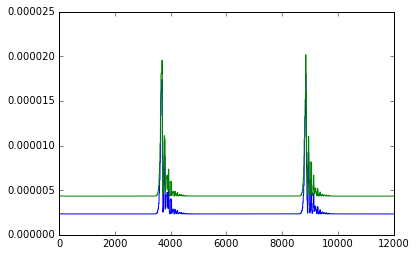

In [41]:
plt.plot(loss[-12000:])
plt.plot(test_loss[-12000:])

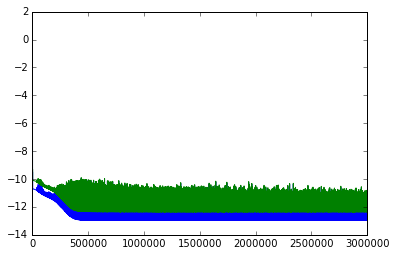

In [32]:
plt.plot([math.log(x) for x in loss])
plt.plot([math.log(x) for x in test_loss])

In [33]:
output, error = evaluate(model, x_chainer_variable, y_chainer_variable)

print(error)

2.3343527573160827e-06


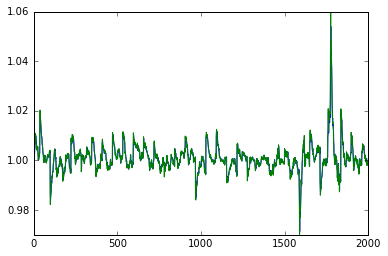

In [34]:
plt.plot(output[:2000])
plt.plot(train_data_y[:2000])

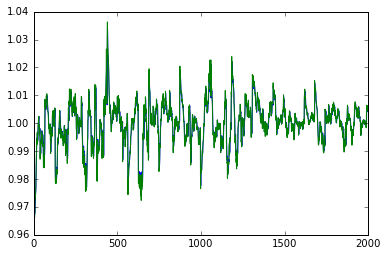

In [35]:
plt.plot(output[4000:6000])
plt.plot(train_data_y[4000:6000])

In [36]:
output, error = evaluate(model, test_data_x_chainer_variable, test_data_y_chainer_variable)
print('test error = {}'.format(error))

test error = 4.33286368206609e-06


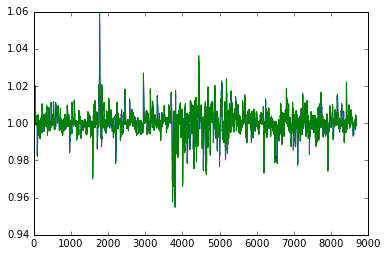

In [50]:
plt.plot(output[0:])
plt.plot(test_data_y[0:])